In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [728]:
def blob_detect(img):
    params = cv2.SimpleBlobDetector_Params()
    params.minThreshold = 10;
    params.maxThreshold = 200;

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 50

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = True 
    params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.01
    is_v2 = cv2.__version__.startswith("2.")
    if is_v2:
        detector = cv2.SimpleBlobDetector(params)
    else:
        detector = cv2.SimpleBlobDetector_create(params)
    
    # Detect blobs.
    keypoints = detector.detect(img)

    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show keypoints
    plt.figure(figsize=(15,15))
    plt.imshow(im_with_keypoints, cmap="gray")
    
def thre1(img):
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    #plt.figure(figsize=(15,15))
    #plt.imshow(thresh, cmap="gray")
    return thresh

def thre2(img):
    thr = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
    plt.figure(figsize=(15,15))
    plt.imshow(thr, cmap="gray")
    return thr
    
def thre3(img):
    thr = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    plt.figure(figsize=(15,15))
    plt.imshow(thr, cmap="gray")
    return thr    

def erosion(img):
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 1)
    #plt.figure(figsize=(15,15))
    #plt.imshow(erosion, cmap="gray")
    return erosion

def dilation(img):
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = 1)
    #plt.figure(figsize=(15,15))
    #plt.imshow(dilation, cmap="gray")
    return dilation


def opening(img):
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    #plt.figure(figsize=(15,15))
    #plt.imshow(opening, cmap="gray")
    return opening

def closing(img):
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    #plt.figure(figsize=(15,15))
    #plt.imshow(closing, cmap="gray")
    return closing

def gradient(img):
    kernel = np.ones((5,5),np.uint8)
    gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
    #plt.figure(figsize=(15,15))
    #plt.imshow(gradient, cmap="gray")
    return gradient



def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def hf(img):
    img = cv2.medianBlur(img,5)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                                param1=25,param2=25,minRadius=0,maxRadius=0)   #param2 30 1, 20
    if circles is None:
        return cimg, 0
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
    
    #plt.figure(figsize=(15,15))
    #plt.imshow(cimg, cmap="gray")
    
    return cimg, circles.shape[1]

/home/shahd/Programs/anaconda3/envs/vision/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


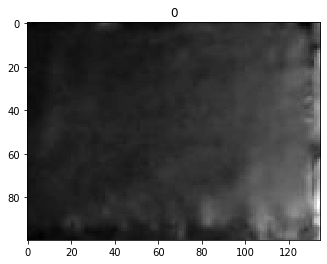

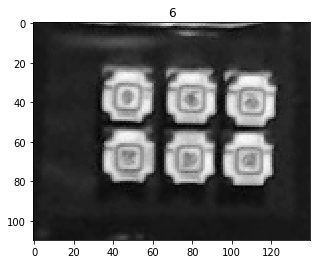

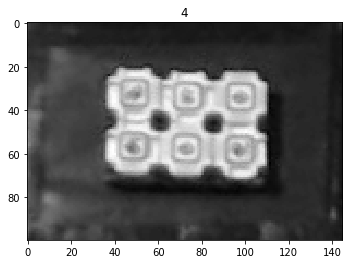

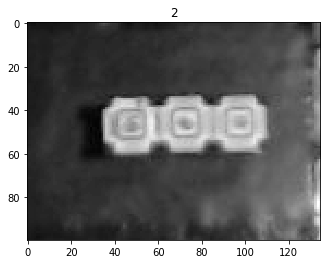

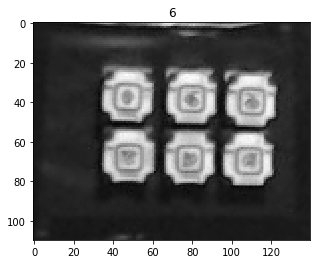

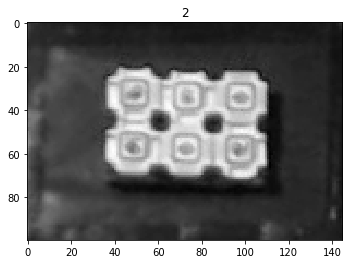

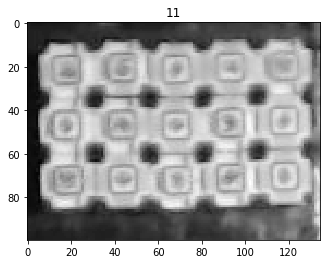

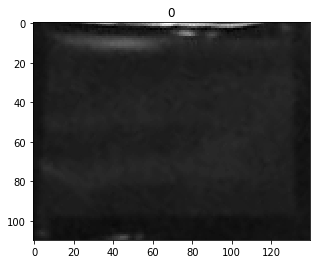

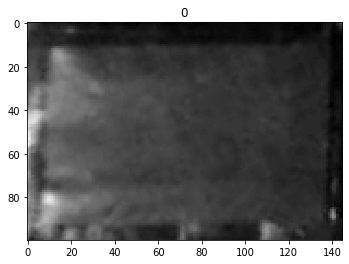

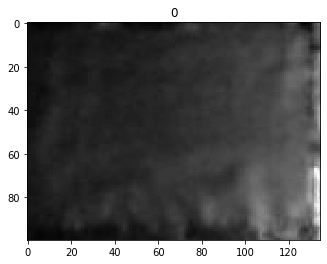

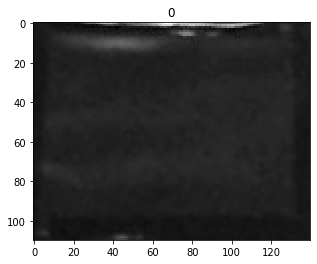

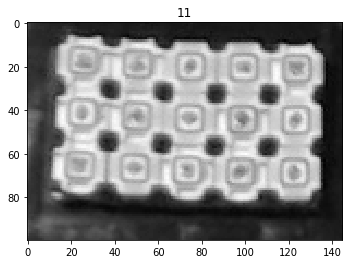

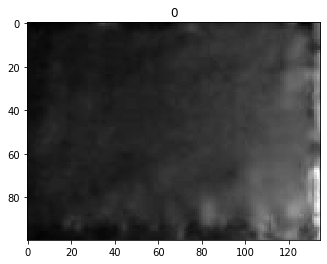

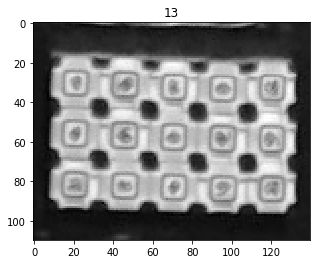

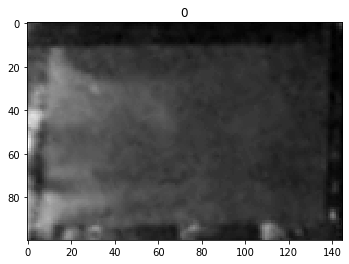

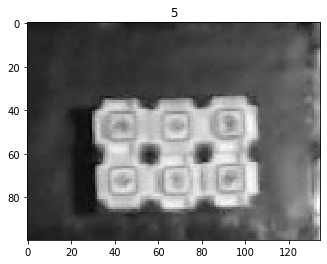

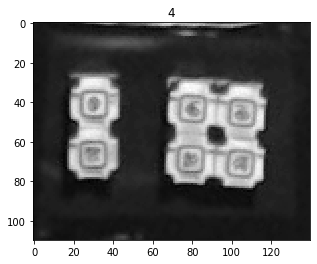

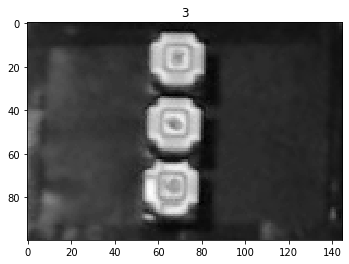

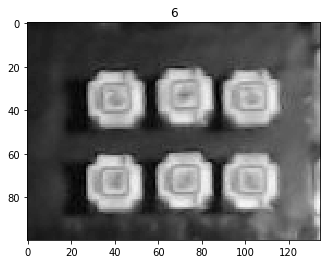

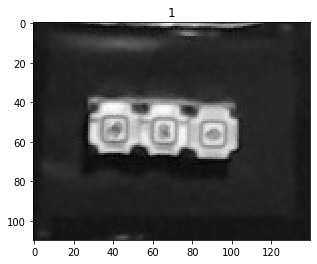

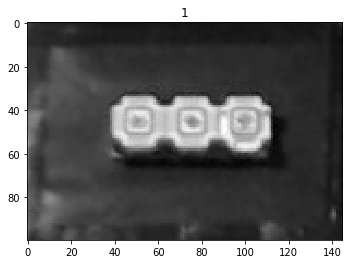

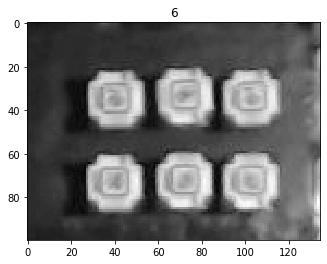

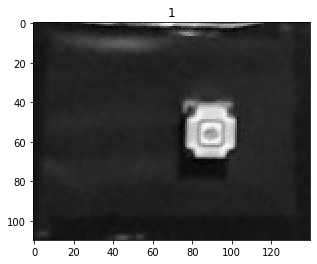

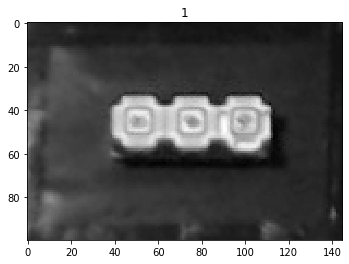

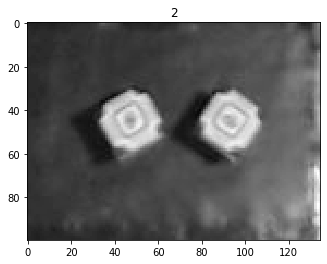

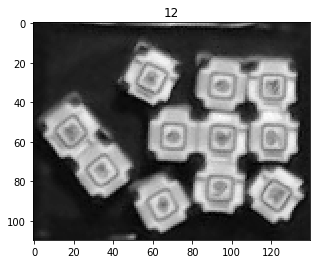

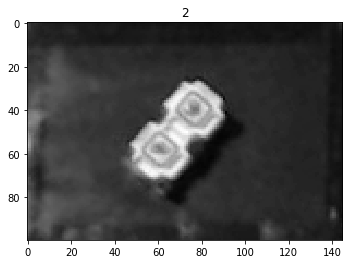

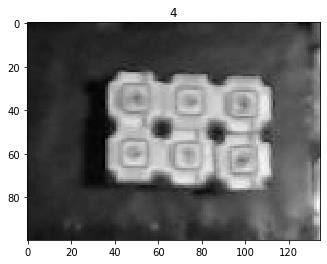

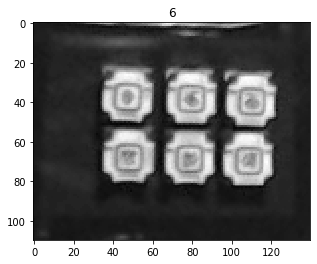

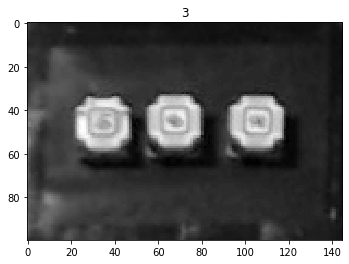

In [740]:




#crop the read img into 3 fronts: left robot, right one and the participant.
#return cropped surfaces in following order: participant, left robo, right robo
def preprocess(img):
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    left_robot_img = rotateImage(gray, 55).copy()
    left_robot_img = left_robot_img[470:580, 420:560]
    
    right_robot_img = rotateImage(gray, 116).copy()
    right_robot_img = right_robot_img[130:230, 425:570]
    
    participant = gray[160:260, 420:555].copy()
    return participant, left_robot_img, right_robot_img


#Place the cubes in distance of each other
#this algorithms works fine with shortly distant cubes and empty surface
#input: cropped surface, output: number of cubes
def count_cubes(img):
    
    thr = thre1(img)
    clos = closing(thr)

    layer = clos.copy()
    gaussian_pyramid = [layer]
    for i in range(6):
        layer = cv2.pyrDown(layer)
        gaussian_pyramid.append(layer)
    # Laplacian Pyramid
    layer = gaussian_pyramid[5]
    #cv2.imshow("6", layer)
    laplacian_pyramid = [layer]
    for i in range(5, 0, -1):
        size = (gaussian_pyramid[i - 1].shape[1], gaussian_pyramid[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i], dstsize=size)
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
        
    lay = laplacian_pyramid[-1]

    #blob_detect(lay)
    _, nr = hf(lay)
    
    return nr

import os
for f in os.listdir('./vision_data/Webcam/'):
    img = cv2.imread('./vision_data/Webcam/%s'%f)
    p, l, r = preprocess(img)
    for i in [p, l, r]:
        plt.figure()
        plt.imshow(i, cmap="gray")
        plt.title("%s"%count_cubes(i))




In [553]:
#lap[-1] -> thre3 -> closing -> blob
#thre1, closing, lap[-1], hf / blob for distant cubes